# PINN Burgers TF2 GPU

*Last edited 2023-05-05*

TensorFlow v2 implementation of Raissi PINN: https://github.com/maziarraissi/PINNs/blob/master/appendix/continuous_time_inference%20(Burgers)/Burgers.py

Based on the work of Morzaria: https://github.com/deepmorzaria/Physics-Informed-Neural-Network-PINNs---TF-2.0/blob/master/PINNs_2.ipynb

Running on GPU Nvidia GeForce GTX 1050 3GB 6.1

## Libraries and initialization

- pyDOE lhs: latin square if (and only if) there is only one sample in each row and each column
( https://en.wikipedia.org/wiki/Latin_hypercube_sampling )

In [1]:
import os, logging, sys
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
    sys.exit([1])
print(tf.__version__)

2023-02-08 09:30:45.181205: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPU found
2.11.0


2023-02-08 09:30:46.599206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 09:30:47.047027: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 2329 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [2]:
import tensorflow_probability as tfp
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Sequential, load_model
from tensorflow.python.client import device_lib
from keras.utils.vis_utils import plot_model
from scipy.io import loadmat
from pyDOE import lhs
from numba import cuda
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
tf.random.set_seed(1234)
np.random.seed(1234)
tf.keras.backend.clear_session()

In [8]:
np.set_printoptions(linewidth=132, precision=6)

In [5]:
# mixed_precision.set_global_policy('mixed_float16')
tf.keras.backend.set_floatx("float64")

## Some parameters

In [6]:
N_u = 100  # no_of_collocation_points (100)
N_f = 10000  # no_of_interior_points (10000)
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]
nu = 0.01 / np.pi

## Data
- burgers_shock.mat: "MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017"
- https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat

In [7]:
DATA_BURGERS = r"data/burgers_shock.mat"  # from Raissi
DATA_T025    = r"data/t=0.25.xlsx"
DATA_T050    = r"data/t=0.50.xlsx"
DATA_T075    = r"data/t=0.75.xlsx"

In [8]:
actual_outputs_1 = pd.read_excel(DATA_T025)
actual_outputs_2 = pd.read_excel(DATA_T050)
actual_outputs_3 = pd.read_excel(DATA_T075)
data = loadmat(DATA_BURGERS)

These contain data for the actual output of PDE at t=0.25,0.50,0.75 which would later used to compare with the predicted output of neural network.

\
Extracting input and outputs from data

In [9]:
x = data['x']  # (256,1)      x varies from [-1,1]
t = data['t']  # (100,1)      t varies from [0,1]
Exact = data['usol'].T  #(100,256)

In [10]:
x.shape, t.shape, Exact.shape

((256, 1), (100, 1), (100, 256))

- flatten() will return a list of numbers; [:,None] converts it to list of list
- X_star (25600,2) : set of points for each time instant
- u_star (25600,1) : ouputs for each (x,t)

In [11]:
X, T = np.meshgrid(x, t)  # X-(100,256)  T-(100,256)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

In [12]:
X.shape, T.shape, X_star.shape, u_star.shape

((100, 256), (100, 256), (25600, 2), (25600, 1))

## Boundary (BC) and initial (IC) conditions

In [13]:
# data for initial boundary condition
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
# data for boundary condition for x=-1
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
# data for boundary condition for x=1
xx3 = np.hstack((X[:, -1:], T[:, -1:]))

In [14]:
xx1.shape, xx2.shape, xx3.shape

((256, 2), (100, 2), (100, 2))

In [15]:
uu1 = Exact[0:1, :].T
uu2 = Exact[:, 0:1]
uu3 = Exact[:, -1:]

In [16]:
uu1.shape, uu2.shape, uu3.shape

((256, 1), (100, 1), (100, 1))

In [17]:
lb = X_star.min(axis=0)
ub = X_star.max(axis=0)

In [18]:
lb.shape, ub.shape, lb, ub

((2,), (2,), array([-1.,  0.]), array([1.  , 0.99]))

\
Defined at the beginning of this Notebook:
- no_of_collocation_points (N_u)
- no_of_interior_points (N_f)

In [19]:
# stacking up all data related to bc's
X_u_train = np.vstack([xx1, xx2, xx3])

In [20]:
X_u_train.shape

(456, 2)

In [21]:
X_u_train

array([[-1.        ,  0.        ],
       [-0.99215686,  0.        ],
       [-0.98431373,  0.        ],
       [-0.97647059,  0.        ],
       [-0.96862745,  0.        ],
       [-0.96078431,  0.        ],
       [-0.95294118,  0.        ],
       [-0.94509804,  0.        ],
       [-0.9372549 ,  0.        ],
       [-0.92941176,  0.        ],
       [-0.92156863,  0.        ],
       [-0.91372549,  0.        ],
       [-0.90588235,  0.        ],
       [-0.89803922,  0.        ],
       [-0.89019608,  0.        ],
       [-0.88235294,  0.        ],
       [-0.8745098 ,  0.        ],
       [-0.86666667,  0.        ],
       [-0.85882353,  0.        ],
       [-0.85098039,  0.        ],
       [-0.84313725,  0.        ],
       [-0.83529412,  0.        ],
       [-0.82745098,  0.        ],
       [-0.81960784,  0.        ],
       [-0.81176471,  0.        ],
       [-0.80392157,  0.        ],
       [-0.79607843,  0.        ],
       [-0.78823529,  0.        ],
       [-0.78039216,

In [22]:
# lhs is used to generate random sample of points. 2 is no of variables(x,t).
X_f_train = lb + (ub - lb) * lhs(2, N_f)
# (N_f+456, 2)
X_f_train = np.vstack((X_f_train, X_u_train))
# correspoing to X_u_train
u_train = np.vstack([uu1, uu2, uu3])

In [23]:
X_u_train.shape, X_f_train.shape, X_f_train.shape, u_train.shape

((456, 2), (10456, 2), (10456, 2), (456, 1))

\
X_train and y_train are used in training:

In [24]:
# random sample of collocation points from 456 numbers
idx = np.random.choice(X_u_train.shape[0],
                       N_u,
                       replace=False)

# Those collocation points chosen from boundary conditions data
X_u_train = X_u_train[idx, :]
# Output corresponding to collocation points
u_train = u_train[idx, :]

In [25]:
X_u_train.shape, u_train.shape

((100, 2), (100, 1))

\
Subscript u denotes collocation/boundary points and subscript f denotes interior points:

In [26]:
x_u = X_u_train[:, 0:1]  #Separating x,t from X_u_train
t_u = X_u_train[:, 1:2]
x_f = X_f_train[:, 0:1]
t_f = X_f_train[:, 1:2]

\
Converting to tensor varialble. Essential for calculating gradients later on:

In [27]:
x_u_tf = tf.Variable(x_u)
t_u_tf = tf.Variable(t_u)
x_f_tf = tf.Variable(x_f)
t_f_tf = tf.Variable(t_f)
X_f_train_tf = tf.Variable(X_f_train)

2023-02-07 22:04:28.343622: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1819 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


## LBFG-S

LBFG-S, which is second order optimizer, has been used to update the weights and biases because conventional first order optimizers Adam, Gradient descent and RMSprop are slow to converge. LBFG-S is not available by default in Tensorflow 2.0 and hence a function from [Tensorflow Probability](https://www.tensorflow.org/probability) has been used. This has not been coded by me except for a minor addition to loss function (check the `loss_valu` variable). Please refer to [this link](https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993) to get a better idea.


In [28]:
def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later,
    # so we need to prepare required information first
    count = 0
    idx = []  # stitch indices
    part = []  # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count + n, dtype=tf.int32),
                              shape))
        part.extend([i] * n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """
        # use GradientTape so that we can calculate the
        # gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            int_loss = interior_loss()
            loss_value = loss_value + int_loss

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them
    # outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

## Model

In [29]:
num_layers = len(layers)

model = Sequential(
    [
        # Input layer
        Dense(
            layers[1],
            activation="tanh",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            input_shape=(layers[0],),
            name="Hidden_Layer_1",
        )
    ]
)

# Hidden layers
for i in range(num_layers - 3):
    model.add(
        Dense(
            layers[i + 2],
            activation="tanh",
            kernel_initializer=tf.keras.initializers.GlorotNormal(),
            name="Hidden_Layer_" + str(i + 2),
        )
    )

# Output layer
model.add(Dense(layers[num_layers - 1], name="Output_Layer"))

In [30]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 20)                60        
                                                                 
 Hidden_Layer_2 (Dense)      (None, 20)                420       
                                                                 
 Hidden_Layer_3 (Dense)      (None, 20)                420       
                                                                 
 Hidden_Layer_4 (Dense)      (None, 20)                420       
                                                                 
 Hidden_Layer_5 (Dense)      (None, 20)                420       
                                                                 
 Hidden_Layer_6 (Dense)      (None, 20)                420       
                                                                 
 Hidden_Layer_7 (Dense)      (None, 20)                4

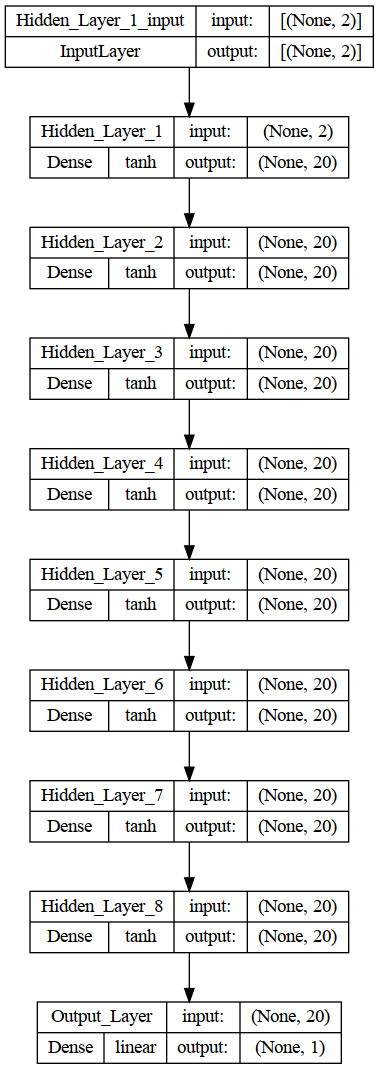

In [31]:
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
)

## Parameters

In [32]:
func = function_factory(
    model, tf.keras.losses.MeanSquaredError(), X_u_train, u_train
)
init_params = tf.dynamic_stitch(func.idx, model.trainable_variables)

## Differential equation definition

Function for calculating loss wrt to interior points

In [33]:
def interior_loss():
    with tf.GradientTape() as tape:
        tape.watch(X_f_train_tf)
        with tf.GradientTape() as tape2:
            u_predicted = model(X_f_train_tf)
        grad = tape2.gradient(u_predicted, X_f_train_tf)
        du_dx = grad[:, 0]
        du_dt = grad[:, 1]
    j = tape.gradient(grad, X_f_train_tf)
     
    d2u_dx2 = j[:, 0]
    
    du_dx = tf.reshape(du_dx, [N_f + 456, 1])
    d2u_dx2 = tf.reshape(d2u_dx2, [N_f + 456, 1])
    du_dt = tf.reshape(du_dt, [N_f + 456, 1])

    u_predicted = tf.cast(u_predicted, dtype=tf.float64)
    f = du_dt + u_predicted * du_dx - nu * d2u_dx2
    f = tf.math.reduce_mean(tf.math.square(f))

    return f

    Float Tensor: 32-bit float
    Double Tensor: 64-bit float
    Half Tensor: 16-bit float
    Int Tensor: 32-bit int
    Long Tensor: 64-bit int

## Optimizer | Training

In [34]:
%%time
results = tfp.optimizer.lbfgs_minimize(
    value_and_gradients_function=func,
    initial_position=init_params,
    max_iterations=1000,
)

Iter: 1 loss: 0.25575315924313569
Iter: 2 loss: 17.766784986769363
Iter: 3 loss: 0.21236530966033187
Iter: 4 loss: 0.20316927050745948
Iter: 5 loss: 0.20313658849851957
Iter: 6 loss: 0.20250041777760802
Iter: 7 loss: 0.20056280060463996
Iter: 8 loss: 0.2100259178091094
Iter: 9 loss: 0.19970850003970333
Iter: 10 loss: 0.19316831864639264
Iter: 11 loss: 0.17397007275781309
Iter: 12 loss: 0.85253006650492225
Iter: 13 loss: 0.17335135579277874
Iter: 14 loss: 0.19521429294555864
Iter: 15 loss: 0.16446174485971049
Iter: 16 loss: 0.1550859101356552
Iter: 17 loss: 0.31600978267012553
Iter: 18 loss: 0.15506819837799543
Iter: 19 loss: 0.15018840490788954
Iter: 20 loss: 0.15789652728838141
Iter: 21 loss: 0.14789455125248738
Iter: 22 loss: 0.13905863242571331
Iter: 23 loss: 0.18051813443405276
Iter: 24 loss: 0.13680772308819117
Iter: 25 loss: 0.13609322005689584
Iter: 26 loss: 0.13483308649889025
Iter: 27 loss: 0.13365640039219356
Iter: 28 loss: 0.14245323881978178
Iter: 29 loss: 0.133522283994773

In [35]:
results

LBfgsOptimizerResults(converged=<tf.Tensor: shape=(), dtype=bool, numpy=False>, failed=<tf.Tensor: shape=(), dtype=bool, numpy=False>, num_iterations=<tf.Tensor: shape=(), dtype=int32, numpy=1000>, num_objective_evaluations=<tf.Tensor: shape=(), dtype=int32, numpy=2844>, position=<tf.Tensor: shape=(3021,), dtype=float64, numpy=
array([ 1.59187628,  0.07726306, -0.22663638, ...,  0.90810289,
        0.21403955,  0.21363041])>, objective_value=<tf.Tensor: shape=(), dtype=float64, numpy=0.0010071996065696698>, objective_gradient=<tf.Tensor: shape=(3021,), dtype=float64, numpy=
array([-1.67232339e-04,  5.08634207e-05, -1.45803758e-04, ...,
        3.72352866e-04,  1.12016370e-04, -2.91174835e-04])>, position_deltas=<tf.Tensor: shape=(10, 3021), dtype=float64, numpy=
array([[-2.23003267e-05,  1.60991569e-04, -5.56806955e-05, ...,
        -1.64732510e-05, -4.48137605e-05, -8.85024169e-05],
       [ 7.98246605e-05, -2.22269169e-04,  8.36258748e-05, ...,
         2.35605824e-06,  9.65079886e-0

In [36]:
func.assign_new_model_parameters(results.position)

In [37]:
model.save('burgers230205.h5')

In [38]:
teste=load_model('burgers230205.h5')

## Predict

In [39]:
#tf.keras.backend.set_floatx('float32')
#mixed_precision.set_global_policy('float32')

In [40]:
%%time
qf = model.predict(X_f_train)

327/327 [==============================] - 0s 937us/step
CPU times: user 694 ms, sys: 45.1 ms, total: 740 ms
Wall time: 1.11 s


In [41]:
%%time
qu = model.predict(X_u_train)

4/4 [==============================] - 0s 1ms/step
CPU times: user 53.5 ms, sys: 259 µs, total: 53.8 ms
Wall time: 50.9 ms


In [42]:
p = np.vstack([X_f_train, X_u_train])
q = np.vstack([qf, qu])[:, 0]

In [43]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12343432318610038725
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1907490816
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4860778502647238173
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2023-02-07 22:08:22.240512: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /device:GPU:0 with 1819 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1


In [44]:
%%time
with tf.device('/GPU:0'):
    qf = model.predict(X_f_train)

327/327 [==============================] - 0s 849us/step
CPU times: user 426 ms, sys: 25.3 ms, total: 452 ms
Wall time: 406 ms


## Plot

In [45]:
def plot_helper(inputs, outputs, title, fname):
    plt.figure(figsize=(8, 4))
    plt.tricontourf(
        inputs[:, 1], inputs[:, 0], outputs.flatten(), 100
    )
    plt.scatter(
        X_u_train[:, 1], X_u_train[:, 0], marker="x", s=100, c="k"
    )
    plt.xlabel("t")
    plt.ylabel("x")
    plt.title(title)
    plt.colorbar()
    plt.savefig(fname)

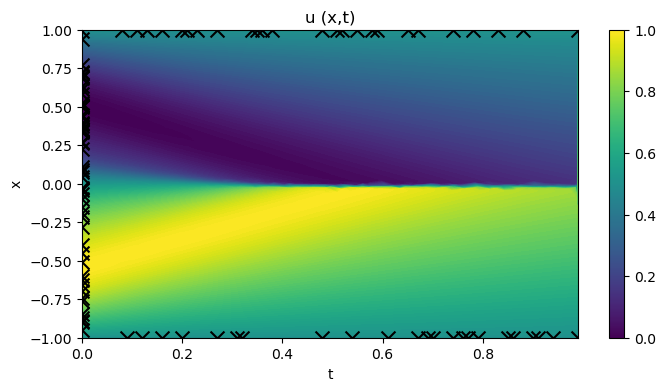

In [46]:
plot_helper(p, q, "u (x,t)", "pred_soln3.pdf")

In [47]:
x_t_25 = np.hstack((X[0:1, :].T, T[25:26, :].T))
x_t_50 = np.hstack((X[0:1, :].T, T[50:51, :].T))
x_t_75 = np.hstack((X[0:1, :].T, T[75:76, :].T))

8/8 [==============================] - 0s 1ms/step


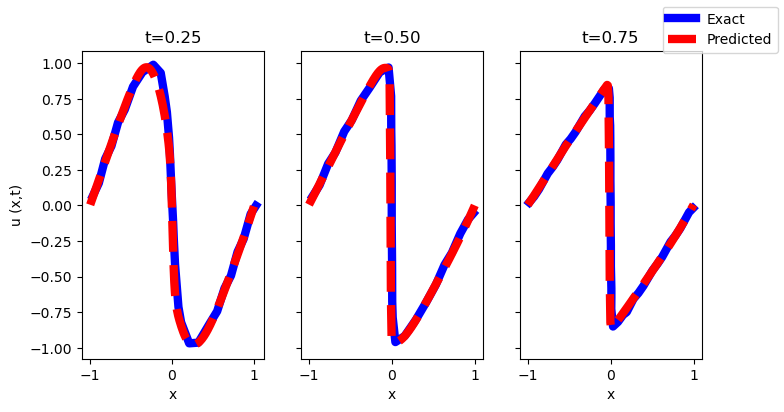

In [48]:
fig, axs = plt.subplots(1, 3, figsize=(8, 4), sharey=True)

# t=0.25
(l1,) = axs[0].plot(
    actual_outputs_1["x"], actual_outputs_1["t"], linewidth=6, color="b"
)
(l2,) = axs[0].plot(
    x_t_25[:, 0],
    model.predict(x_t_25),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[0].set_title("t=0.25")
axs[0].set_xlabel("x")
axs[0].set_ylabel("u (x,t)")

# t=0.50
axs[1].plot(
    actual_outputs_2["x"], actual_outputs_2["t"], linewidth=6, color="b"
)
axs[1].plot(
    x_t_50[:, 0],
    model.predict(x_t_50),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[1].set_title("t=0.50")
axs[1].set_xlabel("x")

# t=0.75
axs[2].plot(
    actual_outputs_3["x"], actual_outputs_3["t"], linewidth=6, color="b"
)
axs[2].plot(
    x_t_75[:, 0],
    model.predict(x_t_75),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[2].set_title("t=0.75")
axs[2].set_xlabel("x")

fig.legend(
    handles=(l1, l2), labels=("Exact", "Predicted"), loc="upper right"
)
# plt.savefig("graphs3.pdf")

## Predict

In [49]:
%%time
r = model.predict(X_u_train)

4/4 [==============================] - 0s 2ms/step
CPU times: user 60.4 ms, sys: 32 µs, total: 60.4 ms
Wall time: 56.9 ms


## Error

In [50]:
error_u = np.linalg.norm(u_train - r, 2) / np.linalg.norm(u_star, 2)
print(error_u)

0.002158955510684045


## GPU

In [52]:
!nvidia-smi

/bin/bash: /home/x/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Tue Feb  7 22:08:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| N/A   77C    P0    N/A /  N/A |    663MiB /  3072MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+-------

## Release gpu memory

In [51]:
cuda.get_current_device().reset()